<a href="https://colab.research.google.com/github/kallebcintra/Artificial-Intelligence/blob/main/MATEUS_KALLEB_CINTRA_BASTOS_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from inspect import stack
from numpy import arange, meshgrid, hstack
import torch
import math
from matplotlib import pyplot as plt
import random

N = 400               # metade do numero total de amostras do dataset
NOISE = 10            # intensidade do ruido de coleta no dataset
SPLIT_RATIO = 0.5     # porcentagem de dados usados no dataset de treino
BATCH_SIZE = 10       # tamanho do batch usado durante o treinamento
LEARNING_RATE = 0.03  # taxa de aprendizado

# Datasets

In [ ]:
def create_plot(dataset):
  indexes_negative = (dataset.Y == -1).nonzero()
  indexes_positive = (dataset.Y == 1).nonzero()

  plt.scatter(x = [dataset.X[index][0][0] for index in indexes_positive],
              y = [dataset.X[index][0][1] for index in indexes_positive],
              label = 'y = 1',
              s = 5)

  plt.scatter(x = [dataset.X[index][0][0] for index in indexes_negative],
              y = [dataset.X[index][0][1] for index in indexes_negative],
              label = 'y = -1',
              s = 5)

  plt.legend()
  plt.show()
  return

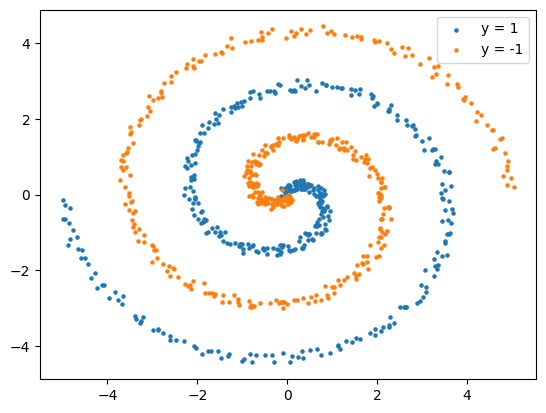

In [ ]:
def genSpiral(delta_t, label):
    r = 5*torch.linspace(0., 1., N+1)[:N]
    t = 0.7*r*math.pi + delta_t
    x0 = r*torch.sin(t)
    x1 = r*torch.cos(t)
    y = label*torch.ones_like(x0)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/70.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class SpiralDataset:
    def __init__(self):
        xp, yp = genSpiral(0, 1) # positive samples
        xn, yn = genSpiral(math.pi, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

dataset = SpiralDataset()
create_plot(dataset)

<ipython-input-4-8fa19b04bbbd>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  x = torch.tensor([cx0, cx1]).T + x*(NOISE/25.)


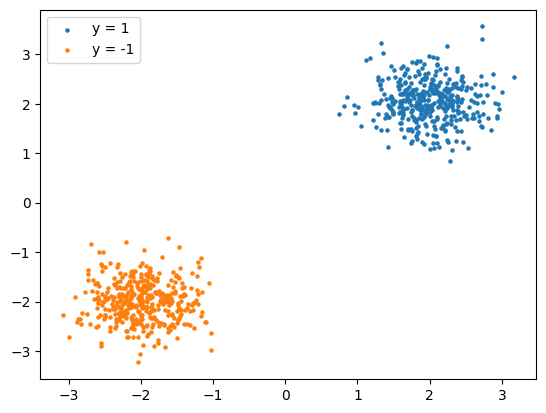

In [ ]:
def genGauss(cx0, cx1, label):
    x = torch.randn(N, 2)
    x = torch.tensor([cx0, cx1]).T + x*(NOISE/25.)
    y = label*torch.ones(N)
    return x, y

class GaussDataset:
    def __init__(self):
        xp, yp = genGauss(2, 2, 1) # positive samples
        xn, yn = genGauss(-2, -2, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

dataset = GaussDataset()
create_plot(dataset)

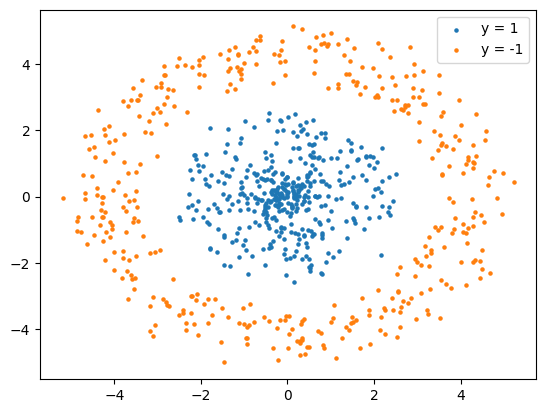

In [ ]:
def genCircle(r_min, r_max, label):
    r = (r_max - r_min)*torch.rand(N) + r_min
    angle = 2*math.pi*torch.rand(N)
    x0 = r*torch.sin(angle)
    x1 = r*torch.cos(angle)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/35.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    y = label*torch.ones_like(x0)
    return x, y

class CircleDataset:
    def __init__(self):
        xp, yp = genCircle(0, 2.5, 1) # positive samples
        xn, yn = genCircle(3.5, 5, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

dataset = CircleDataset()
create_plot(dataset)

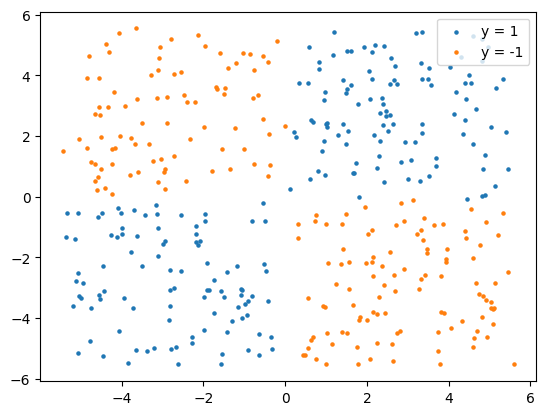

In [ ]:
def genXOR():
    x = 10.*torch.rand(N, 2) - 5.
    y = torch.sign(x[:,0]*x[:,1])
    padding = 0.3
    x += torch.sign(x)*padding
    sampled_noise = (NOISE/25.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class XORDataset:
    def __init__(self):
        self.X, self.Y = genXOR()

dataset = XORDataset()
create_plot(dataset)

# Estrutura da Rede Neural

In [ ]:
def get_X_Y(array):
  return torch.stack([pair[0] for pair in array]), torch.stack([pair[1] for pair in array])

# TODO
def train_test_split(dataset):
    matches = [(X, y) for X, y in zip(dataset.X, dataset.Y)]
    random.shuffle(matches)

    size = int(len(matches) * SPLIT_RATIO)
    train, test = matches[:size], matches[size:]

    X_train, Y_train = get_X_Y(train)
    X_test, Y_test = get_X_Y(test)
    return X_train, Y_train, X_test, Y_test

In [ ]:
# TODO
class Neuron:
    def __init__(self, n_pesos):
        self._weights =  torch.rand(n_pesos, 1, requires_grad = True)
        self._bias = torch.rand(1, requires_grad = True)

    def inference(self, X_values):
        output_value = torch.sigmoid(
            torch.matmul(X_values, self._weights) + self._bias
        )

        # output fica entre -1 e 1
        return (2*output_value - 1)


class Model:
    def __init__(self, layers):
        self.accuracy = 0
        self.accuracy_history = []
        self.epochs = []
        self.losses = []
        self.test_losses = []

        self._network = []

        for layer in layers:
          neurons = [Neuron(n_weights) for n_weights in layer]
          self._network.append(neurons)

    def inference(self, input):
        fwd_input = input

        for layer in self._network:
          output_layer = []

          for neuron in layer:
            output_layer.append(neuron.inference(fwd_input))

          fwd_input = torch.cat(output_layer, dim = 1)

        return fwd_input

    def predict(self, results):
      self.prediction = [1 if result > 0 else -1 for result in results ]

    def plot_graph(self):
        if self.losses and self.epochs:
          plt.subplots(1,2, figsize = (10,4))

          plt.subplot(1,2,1)
          plt.plot(model.epochs, model.losses, label='Treino')
          plt.plot(model.epochs, model.test_losses, label='Teste')
          plt.plot()

          plt.xlabel('Época')
          plt.ylabel('Valor de loss')
          plt.title('Evolução da loss')
          plt.legend()

          plt.subplot(1,2,2)
          plt.plot(model.epochs, model.accuracy_history, label='Precisão')
          plt.title('Evolução da precisão')
          plt.xlabel('Época')
          plt.ylabel('Valor da precisão')
          plt.tight_layout()
        else:
          print('Épocas e loss não calculadas.')

# TODO
class Neuron:
    def __init__(self, n_pesos):
        self._weights =  torch.rand(n_pesos, 1, requires_grad = True)
        self._bias = torch.rand(1, requires_grad = True)

    def inference(self, X_values):
        output_value = torch.sigmoid(
            torch.matmul(X_values, self._weights) + self._bias
        )

        # output fica entre -1 e 1
        return (2*output_value - 1)


class Model:
    def __init__(self, layers):
        self.accuracy = 0
        self.accuracy_history = []
        self.epochs = []
        self.losses = []
        self.test_losses = []

        self._network = []

        for layer in layers:
          neurons = [Neuron(n_weights) for n_weights in layer]
          self._network.append(neurons)

    def inference(self, input):
        fwd_input = input

        for layer in self._network:
          output_layer = []

          for neuron in layer:
            output_layer.append(neuron.inference(fwd_input))

          fwd_input = torch.cat(output_layer, dim = 1)

        return fwd_input

    def predict(self, results):
      self.prediction = [1 if result > 0 else -1 for result in results ]

    def plot_graph(self):
        if self.losses and self.epochs:
          plt.subplots(1,2, figsize = (10,4))

          plt.subplot(1,2,1)
          plt.plot(model.epochs, model.losses, label='Treino')
          plt.plot(model.epochs, model.test_losses, label='Teste')
          plt.plot()

          plt.xlabel('Época')
          plt.ylabel('Valor de loss')
          plt.title('Evolução da loss')
          plt.legend()

          plt.subplot(1,2,2)
          plt.plot(model.epochs, model.accuracy_history, label='Precisão')
          plt.title('Evolução da precisão')
          plt.xlabel('Época')
          plt.ylabel('Valor da precisão')
          plt.tight_layout()
        else:
          print('Épocas e loss não calculadas.')

In [ ]:
def get_loss(y_values, y_hat_values):
    return sum(0.5 * ((y_hat_values - y_values)**2))/len(y_values)

def get_accuracy(predictions, real_values):
  checks = 0

  for pred, val in zip(predictions, real_values):
    if pred == val:
      checks += 1

  return checks / len(real_values)


In [ ]:
def update_variables(model, x_train, y_train, x_test, y_test):
  # guarda loss do treino
  y_hat = model.inference(x_train)
  loss = get_loss(y_train, y_hat)
  model.losses.append(loss.item())

  # guarda loss do teste
  test_inference_value = model.inference(x_test)
  test_loss = get_loss(test_inference_value, y_test)
  model.test_losses.append(test_loss.item())

  # guarda precisoes
  model.predict(test_inference_value)
  model.accuracy = get_accuracy(model.prediction, y_test)
  model.accuracy_history.append(model.accuracy)


In [ ]:
def train_loop(n_epochs, model, x_train, y_train, x_test, y_test):
    trained_model = model

    Y_train_dim = y_train.unsqueeze(1)                                          # corrige as dimensões para estarem iguais
    Y_test_dim = y_test.unsqueeze(1)

    for n in range(1, n_epochs + 1):                                            # inicio do treino de acordo com o numero de epocas
      trained_model.epochs.append(n)
      update_variables(trained_model, x_train, Y_train_dim, x_test, Y_test_dim)

      for n_batch in range(int(len(x_train) / BATCH_SIZE)):                     # itera pelo numero de batches de acordo com BATCH_SIZE

        inicio_batch = BATCH_SIZE * n_batch
        fim_batch = inicio_batch + BATCH_SIZE

        y_hat = trained_model.inference(x_train[inicio_batch:fim_batch])
        loss = get_loss(Y_train_dim[inicio_batch:fim_batch], y_hat)

        if n_batch > 0:
          for layer in trained_model._network:
            for neuron in layer:
              neuron._weights.grad.zero_()
              neuron._bias.grad.zero_()

        loss.backward()
        with torch.no_grad():
          for layer in trained_model._network:
            for neuron in layer:
              neuron._weights -= LEARNING_RATE * neuron._weights.grad
              neuron._bias -= LEARNING_RATE * neuron._bias.grad

      if (n % 100) == 0 or n == 1:
        print(f'Epoch {n: } ---> LOSS: {loss.item():.2f}')
        print(f'Precisão: {trained_model.accuracy}\n\n')

    return trained_model

# Implementação

## Circle Dataset


In [ ]:
x_train, y_train, x_test, y_test = train_test_split(CircleDataset())
model = Model([[2,2,2], [3]])

model = train_loop(600, model, x_train, y_train, x_test, y_test)
print(f'Precisão final do modelo: {model.accuracy}')

Epoch  1 ---> LOSS: 0.49
Precisão: 0.67


Epoch  100 ---> LOSS: 0.10
Precisão: 0.8175


Epoch  200 ---> LOSS: 0.04
Precisão: 0.9975


Epoch  300 ---> LOSS: 0.01
Precisão: 0.995


Epoch  400 ---> LOSS: 0.00
Precisão: 0.9975


Epoch  500 ---> LOSS: 0.00
Precisão: 0.995


Epoch  600 ---> LOSS: 0.00
Precisão: 0.9925


Precisão final do modelo: 0.9925


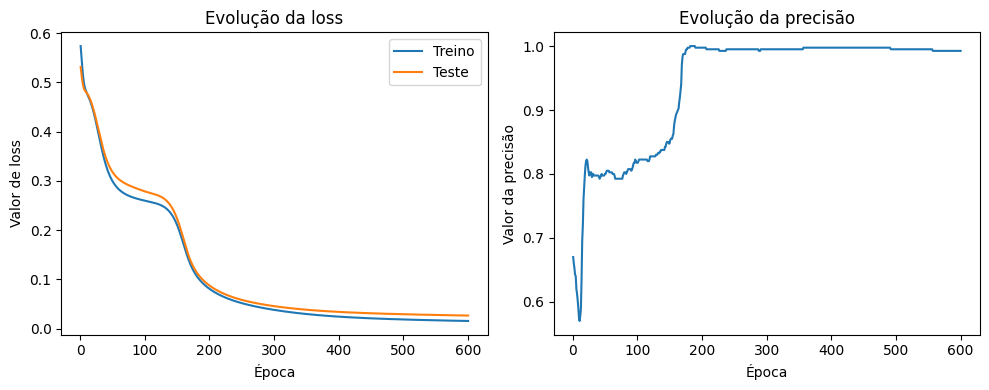

In [ ]:
model.plot_graph()

## Gauss Dataset

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(GaussDataset())
model = Model([[2]])

model = train_loop(10, model, x_train, y_train, x_test, y_test)
print(f'Precisão final do modelo: {model.accuracy}')

Epoch  1 ---> LOSS: 0.03
Precisão: 1.0


Precisão final do modelo: 1.0


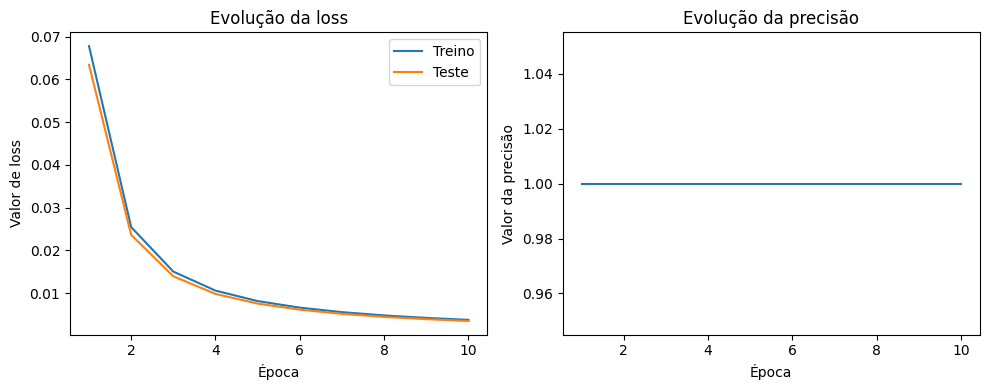

In [ ]:
model.plot_graph()

## XOR Dataset

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(XORDataset())
model = Model([[2,2,2],[3]])

model = train_loop(600, model, x_train, y_train, x_test, y_test)
print(f'Precisão final do modelo: {model.accuracy}')

Epoch  1 ---> LOSS: 0.49
Precisão: 0.365


Epoch  100 ---> LOSS: 0.22
Precisão: 0.9


Epoch  200 ---> LOSS: 0.19
Precisão: 0.905


Epoch  300 ---> LOSS: 0.19
Precisão: 0.905


Epoch  400 ---> LOSS: 0.19
Precisão: 0.9


Epoch  500 ---> LOSS: 0.19
Precisão: 0.895


Epoch  600 ---> LOSS: 0.18
Precisão: 0.895


Precisão final do modelo: 0.895


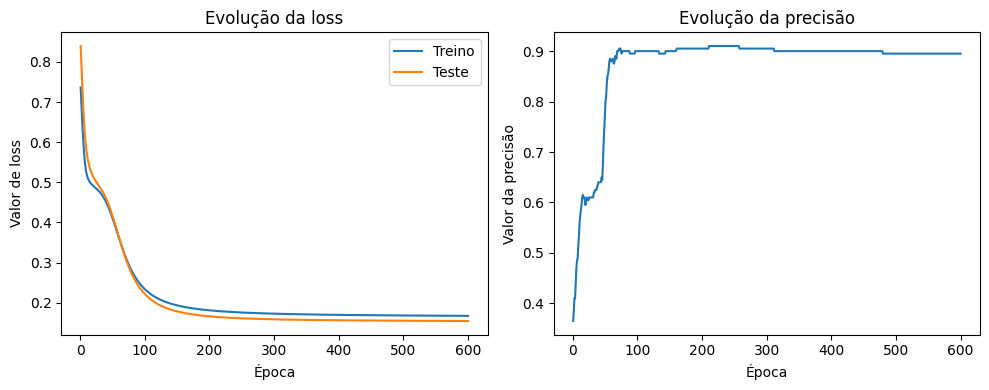

In [ ]:
model.plot_graph()

## Spiral Dataset

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(SpiralDataset())
model = Model([[2,2,2],[3,3], [2]])

model = train_loop(1000, model, x_train, y_train, x_test, y_test)
print(f'Precisão final do modelo: {model.accuracy}')

Epoch  1 ---> LOSS: 0.58
Precisão: 0.465


Epoch  100 ---> LOSS: 0.47
Precisão: 0.605


Epoch  200 ---> LOSS: 0.45
Precisão: 0.605


Epoch  300 ---> LOSS: 0.41
Precisão: 0.58


Epoch  400 ---> LOSS: 0.38
Precisão: 0.5225


Epoch  500 ---> LOSS: 0.37
Precisão: 0.5175


Epoch  600 ---> LOSS: 0.36
Precisão: 0.5175


Epoch  700 ---> LOSS: 0.36
Precisão: 0.515


Epoch  800 ---> LOSS: 0.35
Precisão: 0.515


Epoch  900 ---> LOSS: 0.34
Precisão: 0.52


Epoch  1000 ---> LOSS: 0.33
Precisão: 0.53


Precisão final do modelo: 0.53


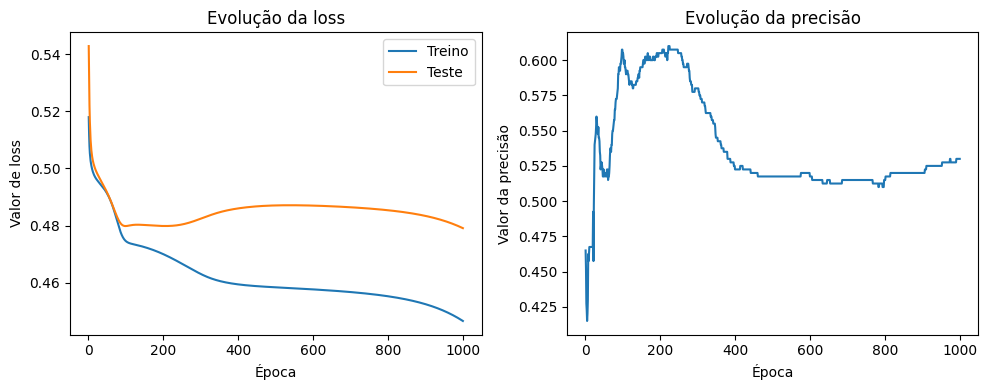

In [ ]:
model.plot_graph()

TypeError: ignored

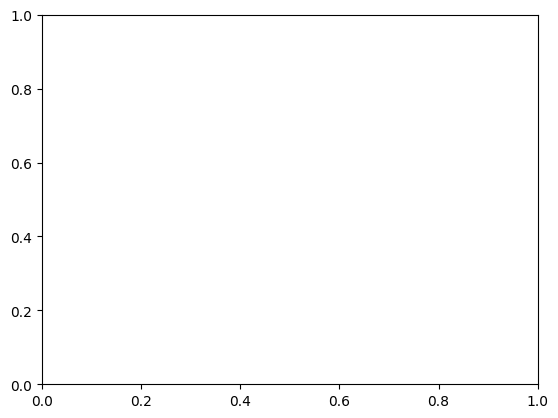

In [ ]:
min1, max1 = -6, 6
min2, max2 = -6, 6

x1grid = arange(min1, max1, 0.1)
x2grid = arange(min2, max2, 0.1)

xx, yy = meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = hstack((r1,r2))

model.predict(model.inference(torch.Tensor(grid)))
yhat = model.prediction

zz = yhat
plt.contourf(xx, yy, zz, cmap='Paired')